In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

## 1. 数据导入与预处理

In [3]:
df=pd.read_csv('/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv')
df.head(5)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
df['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

由于label的分布不均匀，因此我们需要考虑下采样

In [5]:
df_spam=df[df['label']==1]
df_spam.shape

(500, 2)

In [6]:
df_nspam=df[df['label']==0]
df_nspam.shape

(2500, 2)

In [7]:
df_nspam_downsampled=df_nspam.sample(df_spam.shape[0])
df_nspam_downsampled.shape

(500, 2)

In [8]:
df_balanced=pd.concat([df_nspam_downsampled,df_spam])
df_balanced.shape

(1000, 2)

In [9]:
df_balanced['label'].value_counts()

label
0    500
1    500
Name: count, dtype: int64

## 2. 分割数据集

In [10]:
from sklearn.model_selection import train_test_split

X=df_balanced['email']
y=df_balanced['label']

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y)

In [11]:
X_train.head(5)

2526    NUMBER fight the risk of cancer URL NUMBER sli...
2829    du suchst ein sexabenteuer seitensprung one ni...
2645     quotepoolmortgage we re different and it s a ...
1177    james this is not an exmh problem but an inter...
2735    dear user do you ever wish you could easily ca...
Name: email, dtype: object

## 3. Bert初始化

In [12]:
# 文本预处理
bert_preprocess = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
# 文本encoder
bert_encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/4")

在分类问题中，我们常常使用`pooled_output`

In [13]:
def get_sentence_embedding(sentences):
    # 对输入的句子进行处理，例如分词、添加特殊标记、填充等
    preprocessed_text=bert_preprocess(sentences)
    # 调用bert模型并输出pooled_output，整体语义表示
    return bert_encoder(preprocessed_text)['pooled_output']

In [15]:
get_sentence_embedding([
    'Click and get thousands of money',
    'Hey Ali Shohadaee, are you comming tommorrow for festival?' 
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.7468493 , -0.3997798 , -0.79626733, ..., -0.6996809 ,
        -0.61443913,  0.7623512 ],
       [-0.8160964 , -0.40989658, -0.861985  , ..., -0.7979315 ,
        -0.6595044 ,  0.87848836]], dtype=float32)>

### 输出结果解释
1. **形状**：shape=(2, 768) 表示输出是一个包含 2 个句子的张量，每个句子的表示是一个 768 维的向量。
* 2：对应输入的两个句子。
* 768：这是 BERT 模型的隐藏层维度，表示每个句子的语义特征向量。
2. **数据类型**：dtype=float32 表示输出的数据类型是32位浮点数，通常用于表示神经网络中的权重和激活值。
3. **内容**
* 输出中每一行代表一个输入句子的 pooled_output。例如，第一个句子的输出是 [-0.7468493 , -0.3997798 , -0.79626733, ..., -0.6996809 , -0.61443913, 0.7623512 ]，而第二个句子的输出是 [-0.8160964 , -0.40989658, -0.861985 , ..., -0.7979315 , -0.6595044 , 0.87848836]。
* 每个向量的元素表示句子的不同语义特征，具体的数值是由 BERT 模型在训练过程中学习到的，数值的大小和符号通常没有明确的解释，但它们共同构成了句子的语义信息。

检查相似性

In [17]:
words = get_sentence_embedding([
    "MIlk", 
    "Cucumbers",
    "tree",
    "University of Bologna",
    "Ali Shohadaee",
    "Deep Learning",
    "Artificial Intelligence",
    "University of Mazandaran",
    "Machine Learning"
    ])

In [18]:
# 余弦相似度，计算两个向量之间相似性的度量，值的范围在-1到1之间
from sklearn.metrics.pairwise import cosine_similarity
# 比较了两个向量的相似性，是一个矩阵
cosine_similarity([words[3],words[7]])

array([[0.99999964, 0.97753453],
       [0.97753453, 1.        ]], dtype=float32)

## 4. Bert模型构建
模型构建有两种：顺序模型（Sequential）和函数模型（Functional）。
* 顺序模型
旨在创建具有单个输入和输出的模型，层按照顺序堆叠，每一层直接传送到下一层；
* 函数模型
允许创建多个输入和输出的模型。函数式模型允许用户通过定义层之间的连接来构建更加复杂的架构。

### (1) Sequential

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model=Sequential([
    Flatten(input_shape=(28,28)), # 扁平化层
    Dense(128,activation='relu'), # 全连接层
    Dense(10, activation='softmax') # 输出层
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### (2) Functional

In [20]:
from tensorflow.keras.layers import Input,Dense,Concatenate
from tensorflow.keras.models import Model

input_a=Input(shape=(32,))
input_b=Input(shape=(32,))

dense_1=Dense(64,activation='relu')(input_a)
dense_2=Dense(64,activation='relu')(input_b)
concat=Concatenate()([dense_1,dense_2])
output=Dense(1,activation='sigmoid')(concat)

model=Model(inputs=[input_a,input_b],outputs=output)

In [21]:
!pip install tf_keras

In [22]:
import tf_keras as tfk

In [27]:
# Bert layers
# 输入层，接受的是文本数据dtype=tf.string
text_input = tfk.layers.Input(shape=(), dtype=tf.string, name='text')
# 文本预处理：将输入文本转换为Bert模型所接受的格式
preprocessed_text = bert_preprocess(text_input)
# bert编码器：对预处理的文本进行编码
outputs = bert_encoder(preprocessed_text)

# Neural network layers
# dropout层，丢弃10%的神经元，防止模型过拟合（输入到dropout层的是outputs['pooled_output'])
l = tfk.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
# 全连接层，输出维度为1，并使用sigmoid激活函数，表示该模型是用于二分类任务的，输出的值在0到1之间
l = tfk.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tfk.Model(inputs=[text_input], outputs = [l])

# 编译模型，指定优化器、损失函数和评估指标
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [30]:
METRICS=[
    tfk.metrics.BinaryAccuracy(name='accuracy'),
    tfk.metrics.Precision(name='precision'),
    tfk.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

## 5. 训练模型

In [31]:
import numpy as np

In [32]:
# 检查数据类型
# 我们的模型要求网络的数据类型是string
print("X_train data type:",X_train.dtype)
print("y_train data type:",y_train.dtype)

X_train data type: object
y_train data type: int64


In [33]:
X_train = np.array(X_train, dtype=str)
y_train = y_train.astype('float32')

In [35]:
print("y_train new data type:", y_train.dtype)
print("X_train new data type:", X_train.dtype)

y_train new data type: float32
X_train new data type: <U82994


In [36]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
24/24 [==============================] - 190s 7s/step - loss: 0.7188 - accuracy: 0.4747 - precision: 0.4755 - recall: 0.4907
Epoch 2/10
24/24 [==============================] - 158s 7s/step - loss: 0.6823 - accuracy: 0.5640 - precision: 0.5682 - recall: 0.5333
Epoch 3/10
24/24 [==============================] - 158s 7s/step - loss: 0.6470 - accuracy: 0.6160 - precision: 0.6101 - recall: 0.6427
Epoch 4/10
24/24 [==============================] - 157s 7s/step - loss: 0.6432 - accuracy: 0.6307 - precision: 0.6433 - recall: 0.5867
Epoch 5/10
24/24 [==============================] - 157s 7s/step - loss: 0.6224 - accuracy: 0.6853 - precision: 0.6873 - recall: 0.6800
Epoch 6/10
24/24 [==============================] - 158s 7s/step - loss: 0.5962 - accuracy: 0.7067 - precision: 0.7233 - recall: 0.6693
Epoch 7/10
24/24 [==============================] - 157s 7s/step - loss: 0.5840 - accuracy: 0.7040 - precision: 0.6987 - recall: 0.7173
Epoch 8/10
24/24 [==============================

### 输出结果解释
1. epoch 1/10：第一个epoch训练（总共计划训练10个epoch）
2. 24/24：表示有24个批次
3. 190s：这个epoch的训练时间是190秒
4. 7s/step：每个批次平均用时7秒
5. loss：训练后的损失值，表示模型的误差
6. accuracy：模型在训练数据上的准确率，表示预测正确的比例
7. precision：精确率，表示模型正确预测为正的样本占模型所有预测为正的样本的比例
8. recall：召回率，表示模型正确预测为正的样本占真实所有正样本的比例

In [37]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 55s 7s/step - loss: 0.5563 - accuracy: 0.7520 - precision: 0.8987 - recall: 0.5680


[0.5562800765037537,
 0.7519999742507935,
 0.8987341523170471,
 0.5680000185966492]

In [38]:
y_predicted=model.predict(X_test)
y_predicted=y_predicted.flatten()

8/8 [==============================] - 55s 7s/step


In [39]:
def define_predict_class(y_pred):
    return np.where(y_pred>0.5,1,0)

y_predicted=define_predict_class(y_predicted)
y_predicted

array([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0])

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

cm=confusion_matrix(y_test,y_predicted)
cm

array([[117,   8],
       [ 54,  71]])

Text(50.722222222222214, 0.5, 'Truth')

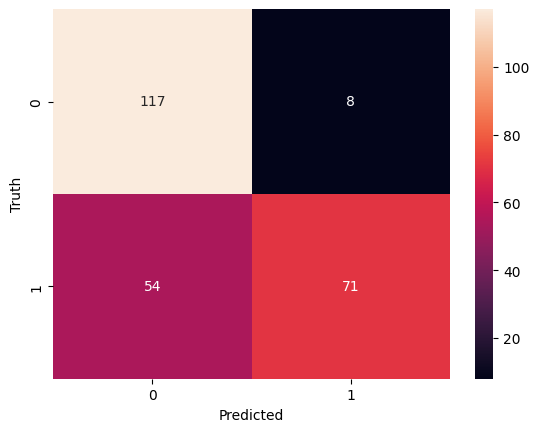

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [42]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.68      0.94      0.79       125
           1       0.90      0.57      0.70       125

    accuracy                           0.75       250
   macro avg       0.79      0.75      0.74       250
weighted avg       0.79      0.75      0.74       250

